In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

from data_util import parse_bj_aq_data, generate_train_samples, generate_test_samples
from multi_variable_seq2seq_model import build_graph
from metrics import SMAPE_on_dataset
from plot_util import plot_forecast_and_actual_example

%load_ext autoreload
%autoreload 2

/home/cvdev/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = tf.Session(config=gpu_config)
KTF.set_session(session)

## Data exploration

In [3]:
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'gucheng_aq', 'fangshan_aq', 'miyun_aq', 'badaling_aq', 'beibuxinqu_aq', 'dingling_aq', 'mentougou_aq', 'dongsi_aq', 'dongsihuan_aq', 'nansanhuan_aq', 'aotizhongxin_aq', 'zhiwuyuan_aq', 'donggaocun_aq', 'yufa_aq', 'fengtaihuayuan_aq', 'pingchang_aq', 'yongdingmennei_aq', 'shunyi_aq', 'xizhimenbei_aq', 'yizhuang_aq', 'wanshouxigong_aq', 'yongledian_aq', 'nongzhanguan_aq', 'miyunshuiku_aq', 'wanliu_aq', 'liulihe_aq', 'pinggu_aq', 'tiantan_aq', 'yungang_aq', 'qianmen_aq', 'daxing_aq', 'huairou_aq', 'yanqin_aq', 'guanyuan_aq', 'tongzhou_aq'}


/home/cvdev/air-quality-prediction/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/home/cvdev/air-quality-prediction/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


### Use part of data(3 stations, version 1) or all data(35 stations, version 2)

In [12]:
# Version 1 : use 3 stations
all_features = bj_aq_stations_merged.dtypes.index
features = [i for i in all_features if 'yizhuang' in i or 'gucheng' in i or 'nongzhanguan' in i]

# use all selected features for input
input_features = features
# just use pm2.5, pm15 and O3 for output
output_features = [i for i in features if "PM2.5" in i or "PM10" in i or "O3" in i]

print("There are %d features in the input and %d features in the output." %(len(input_features), len(output_features)))

There are 18 features in the input and 9 features in the output.


In [4]:
# Version 2 : use all 210 features
all_features = bj_aq_stations_merged.dtypes.index
features = all_features

# use all selected features for input
input_features = features
# just use pm2.5, pm15 and O3 for output
output_features = [i for i in features if "PM2.5" in i or "PM10" in i or "O3" in i]

print("There are %d features in the input and %d features in the output." %(len(input_features), len(output_features)))

There are 210 features in the input and 105 features in the output.


In [5]:
df = bj_aq_stations_merged[features]
df = df.reset_index()
df = df.drop(columns=["format_time"])

In [6]:
# 缺失值处理，缺失值处理当前尽在 .ipynb 中生效，在 .py 文件中不生效
df.fillna(0, inplace=True)
# df.fillna(method="ffill", inplace=True)
df.isnull().values.any()

False

In [7]:
df.head()

,gucheng_aq_PM2.5,gucheng_aq_PM10,gucheng_aq_NO2,gucheng_aq_CO,gucheng_aq_O3,gucheng_aq_SO2,yungang_aq_PM2.5,yungang_aq_PM10,yungang_aq_NO2,yungang_aq_CO,...,guanyuan_aq_NO2,guanyuan_aq_CO,guanyuan_aq_O3,guanyuan_aq_SO2,wanshouxigong_aq_PM2.5,wanshouxigong_aq_PM10,wanshouxigong_aq_NO2,wanshouxigong_aq_CO,wanshouxigong_aq_O3,wanshouxigong_aq_SO2
0,500.0,612.0,161.0,7.7,3.0,11.0,415.0,495.0,136.0,6.4,...,158.0,6.9,2.0,7.0,416.0,474.0,140.0,0.6,7.0,5.0
1,490.0,594.0,150.0,7.9,3.0,11.0,423.0,491.0,131.0,6.5,...,171.0,0.8,2.0,9.0,403.0,469.0,139.0,6.1,6.0,5.0
2,513.0,618.0,157.0,8.7,4.0,11.0,449.0,502.0,127.0,6.9,...,171.0,7.7,2.0,9.0,389.0,461.0,138.0,6.5,6.0,4.0
3,528.0,609.0,170.0,9.9,4.0,13.0,469.0,502.0,122.0,6.8,...,164.0,7.5,2.0,9.0,403.0,459.0,133.0,6.9,7.0,5.0
4,297.0,609.0,92.0,4.4,15.0,11.0,421.0,423.0,119.0,6.8,...,148.0,6.6,2.0,10.0,413.0,479.0,126.0,6.6,7.0,5.0


## Preprocessing - there are many other ways

In [8]:
## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

## take out the useful columns for modeling
X_train = df_train.loc[:, input_features].values.copy()
X_test = df_test.loc[:, input_features].values.copy()

y_train = df_train[output_features].values.copy()
y_test = df_test[output_features].values.copy()

In [9]:
print("number of training data to be used, features")
print(X_train.shape, y_train.shape)
print("number of testing data to be used, features")
print(X_test.shape, y_test.shape)

number of training data to be used, features
(9554, 210) (9554, 105)
number of testing data to be used, features
(744, 210) (744, 105)


In [10]:
## z-score transform x
for i in range(X_train.shape[1]):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [11]:
# define parameters here
batch_size = 32
input_seq_len = 120
output_seq_len = 48

In [12]:
x, y = generate_train_samples(x=X_train, y=y_train, batch_size=batch_size, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
print("batch_size, input/output_seq_length, features")
print(x.shape, y.shape)

batch_size, input/output_seq_length, features
(32, 120, 210) (32, 48, 105)


In [13]:
test_x, test_y = generate_test_samples(X_test, y_test, input_seq_len, output_seq_len)
print(test_x.shape, test_y.shape)

(576, 120, 210) (576, 48, 105)


## Building the model and train the model 

In [15]:
total_iteractions = 200
batch_size = 128
KEEP_RATE = 0.5
train_losses = []
val_losses = []

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    losses = []
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(x=X_train, y=y_train, batch_size=batch_size, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        if i%10 == 0:
            print("loss after %d/%d iteractions : %.3f" %(i, total_iteractions, loss_t))
        losses.append(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./seq2seq_results/', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
loss after 0/200 iteractions : 153.843
loss after 10/200 iteractions : 91.076
loss after 20/200 iteractions : 84.583
loss after 30/200 iteractions : 82.130
loss after 40/200 iteractions : 78.950
loss after 50/200 iteractions : 73.604
loss after 60/200 iteractions : 73.286
loss after 70/200 iteractions : 73.293
loss after 80/200 iteractions : 71.546
loss after 90/200 iteractions : 71.918
loss after 100/200 iteractions : 69.701
loss after 110/200 iteractions : 71.242
loss after 120/200 iteractions : 69.177
loss after 130/200 iteractions : 69.234
loss after 140/200 iteractions : 69.211
loss after 150/200 iteractions : 66.686
loss after 160/200 iteractions : 68.182
loss after 170/200 iteractions : 68.485
loss after 180/200 iteractions : 67.224
loss after 190/200 iteractions : 67.292
Checkpoint saved at:  ./seq2seq_results/multivariate_ts_pollution_case


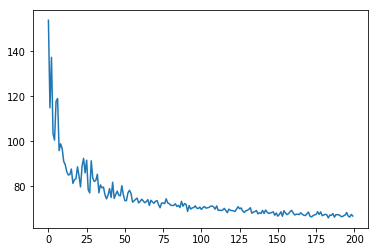

In [16]:
%matplotlib inline
plt.plot(losses)

## Inference on test 
Notice the batch prediction which is different to previous

In [19]:
# length of input signals
input_seq_len = 120
# length of output signals
output_seq_len = 48
# num of input signals
input_dim = 210
# num of output signals
output_dim = 105

In [20]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./seq2seq_results/', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./seq2seq_results/multivariate_ts_pollution_case
Test mse is:  3.122297245707786


In [21]:
final_preds.mean()

0.26008743

### Example of many featutres

In [22]:
print(output_features)

['gucheng_aq_PM2.5', 'gucheng_aq_PM10', 'gucheng_aq_O3', 'yungang_aq_PM2.5', 'yungang_aq_PM10', 'yungang_aq_O3', 'xizhimenbei_aq_PM2.5', 'xizhimenbei_aq_PM10', 'xizhimenbei_aq_O3', 'yizhuang_aq_PM2.5', 'yizhuang_aq_PM10', 'yizhuang_aq_O3', 'fangshan_aq_PM2.5', 'fangshan_aq_PM10', 'fangshan_aq_O3', 'miyun_aq_PM2.5', 'miyun_aq_PM10', 'miyun_aq_O3', 'badaling_aq_PM2.5', 'badaling_aq_PM10', 'badaling_aq_O3', 'beibuxinqu_aq_PM2.5', 'beibuxinqu_aq_PM10', 'beibuxinqu_aq_O3', 'yongledian_aq_PM2.5', 'yongledian_aq_PM10', 'yongledian_aq_O3', 'dingling_aq_PM2.5', 'dingling_aq_PM10', 'dingling_aq_O3', 'mentougou_aq_PM2.5', 'mentougou_aq_PM10', 'mentougou_aq_O3', 'miyunshuiku_aq_PM2.5', 'miyunshuiku_aq_PM10', 'miyunshuiku_aq_O3', 'dongsi_aq_PM2.5', 'dongsi_aq_PM10', 'dongsi_aq_O3', 'dongsihuan_aq_PM2.5', 'dongsihuan_aq_PM10', 'dongsihuan_aq_O3', 'nansanhuan_aq_PM2.5', 'nansanhuan_aq_PM10', 'nansanhuan_aq_O3', 'tiantan_aq_PM2.5', 'tiantan_aq_PM10', 'tiantan_aq_O3', 'liulihe_aq_PM2.5', 'liulihe_aq_PM

/home/cvdev/tf/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


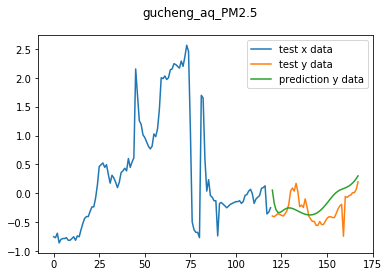

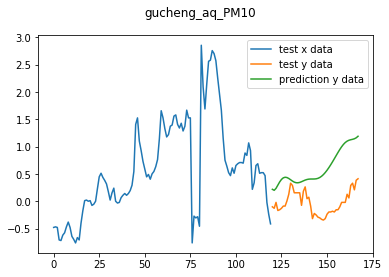

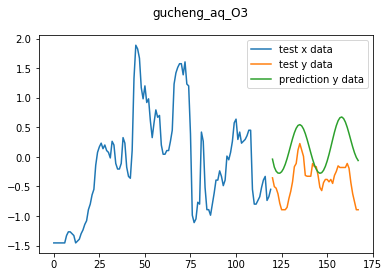

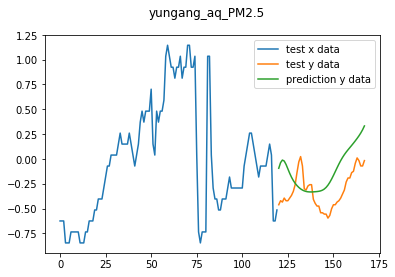

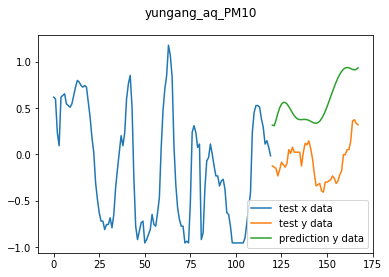

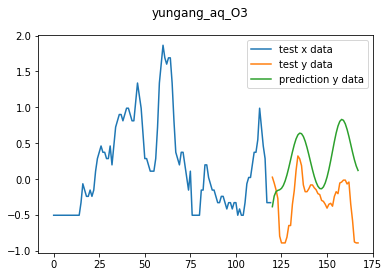

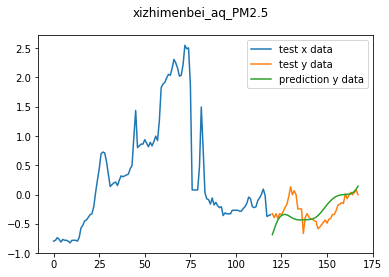

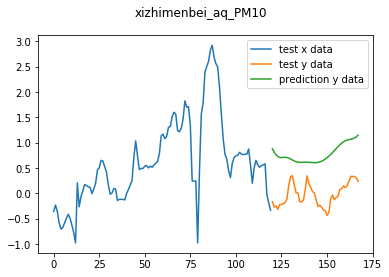

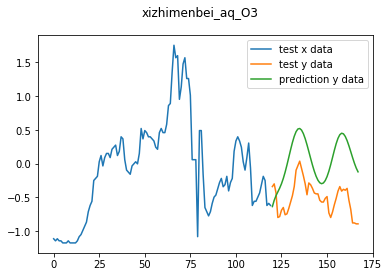

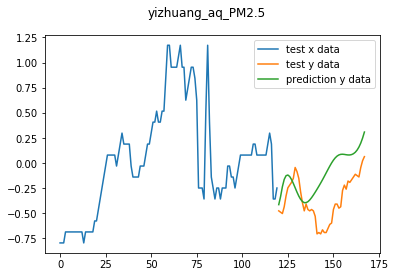

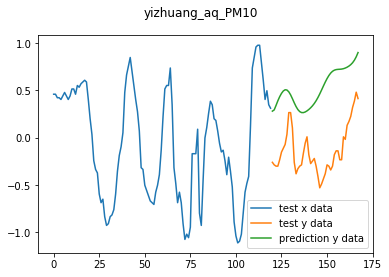

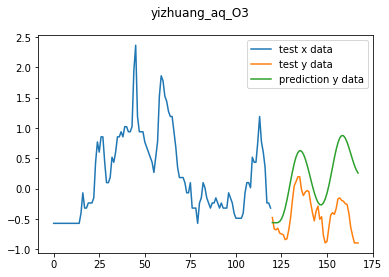

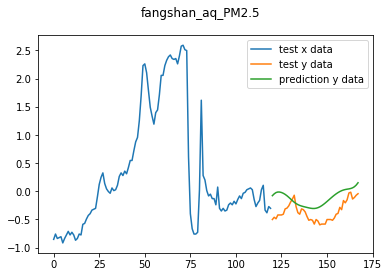

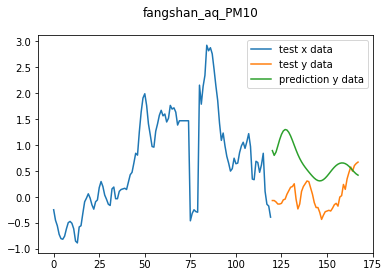

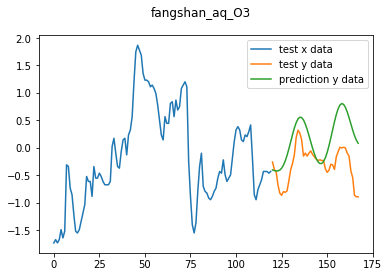

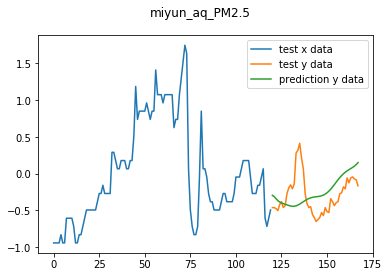

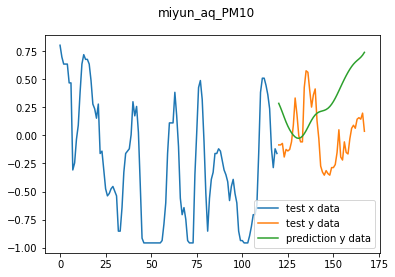

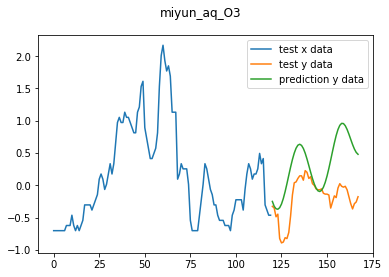

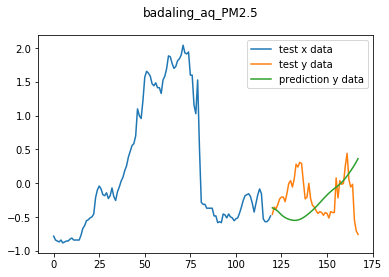

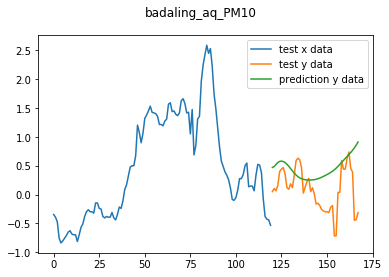

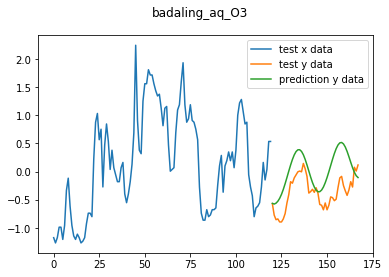

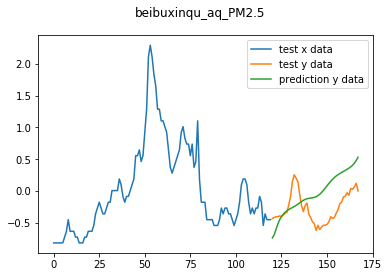

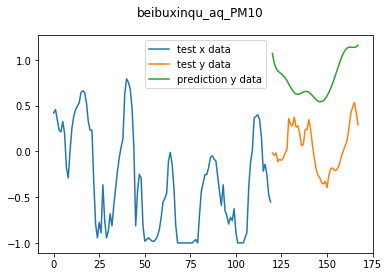

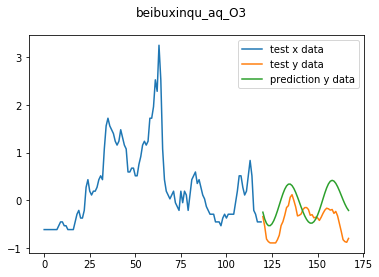

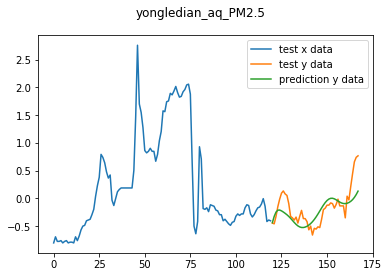

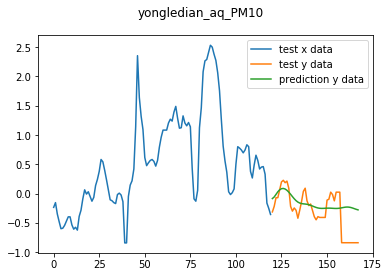

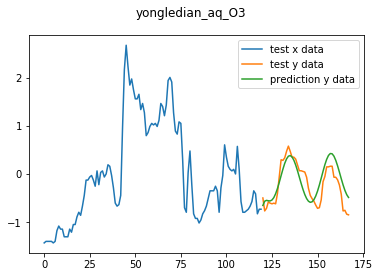

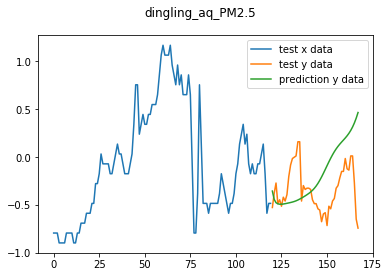

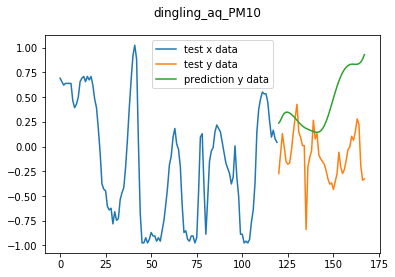

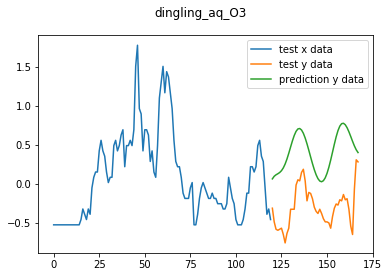

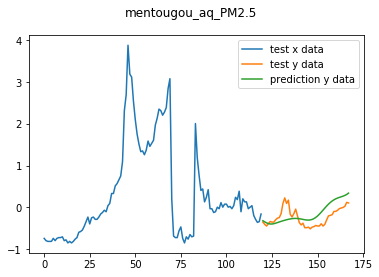

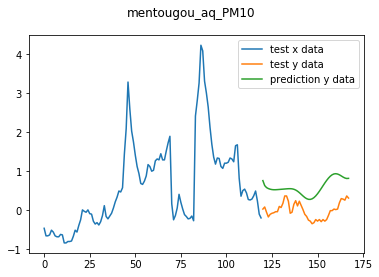

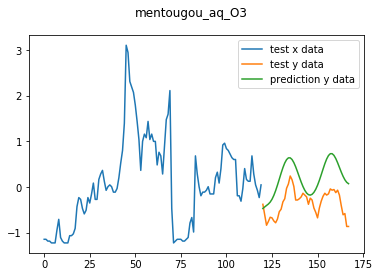

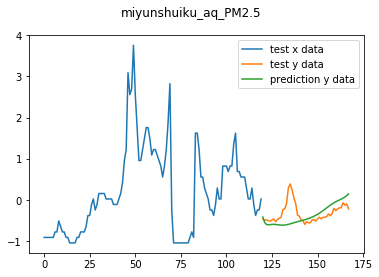

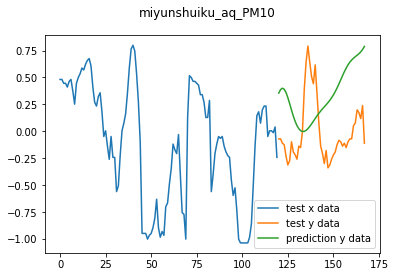

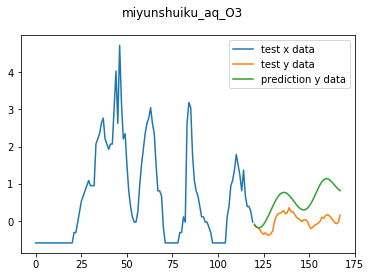

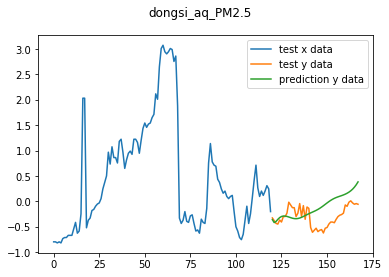

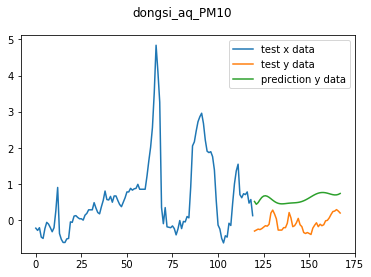

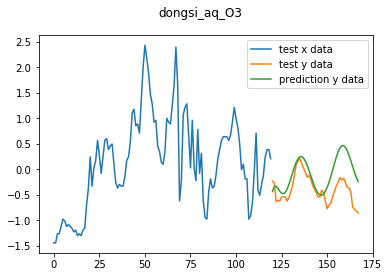

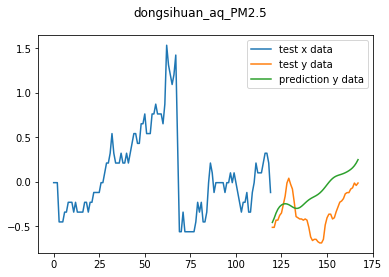

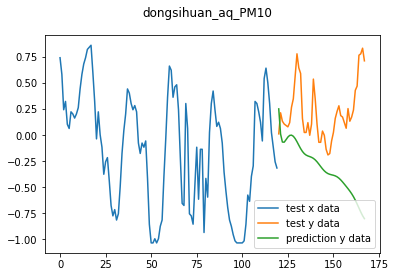

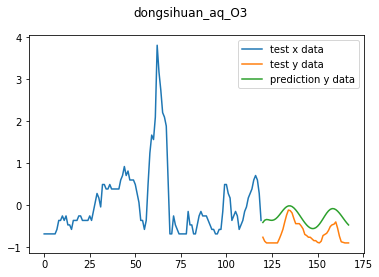

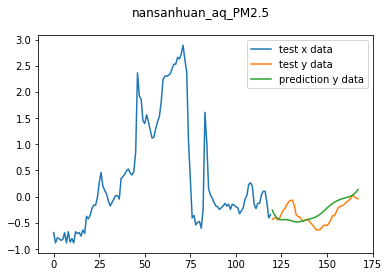

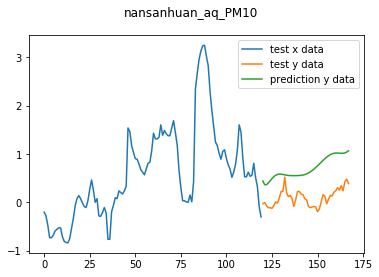

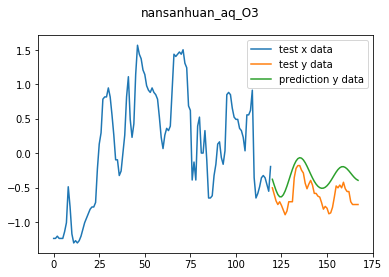

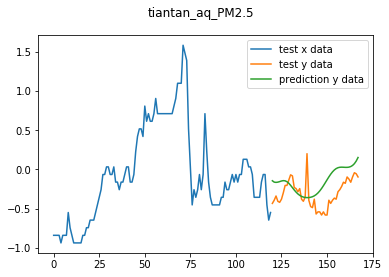

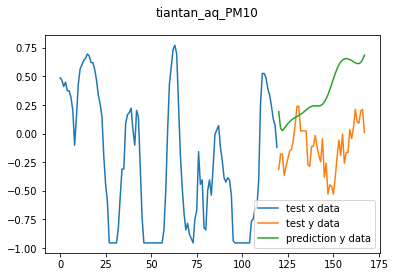

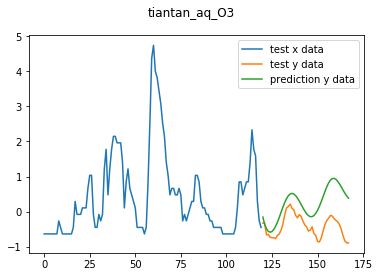

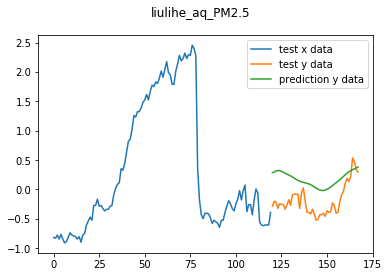

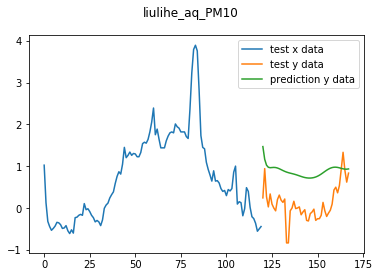

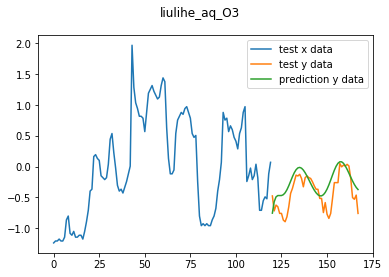

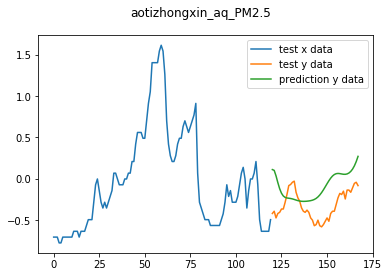

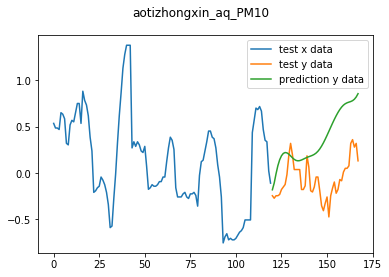

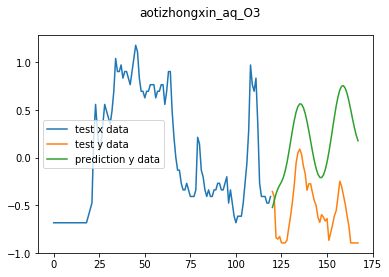

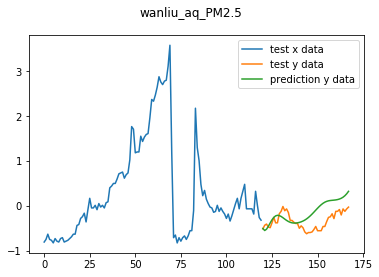

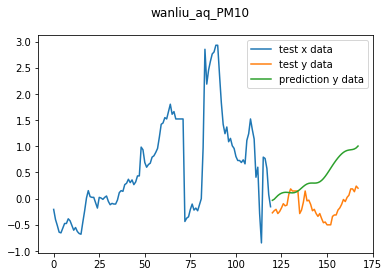

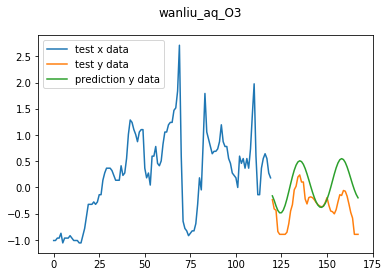

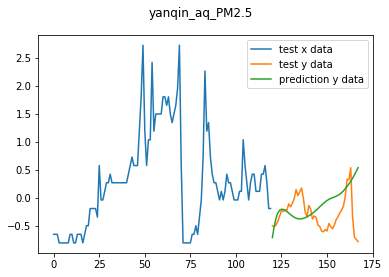

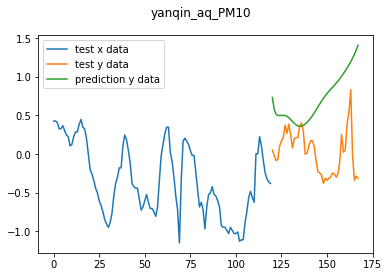

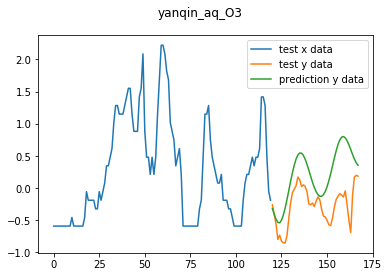

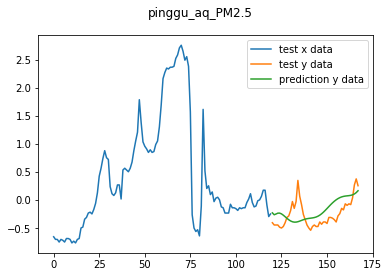

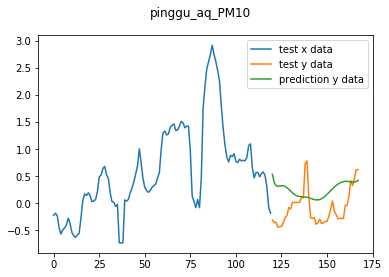

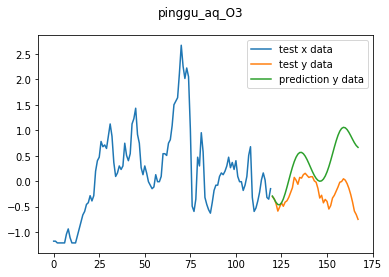

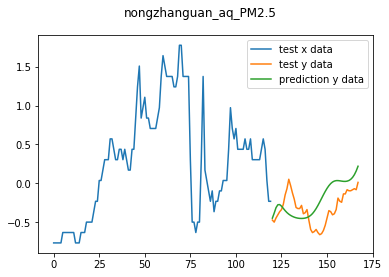

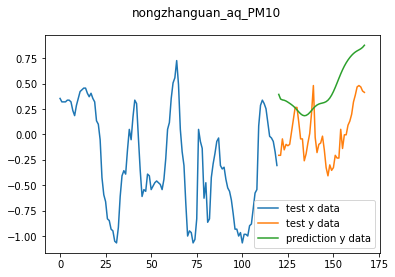

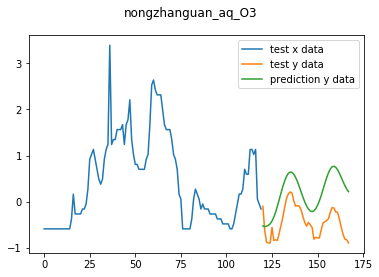

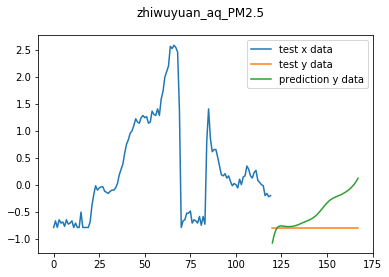

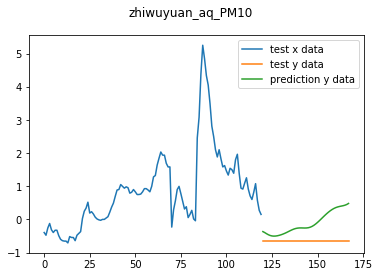

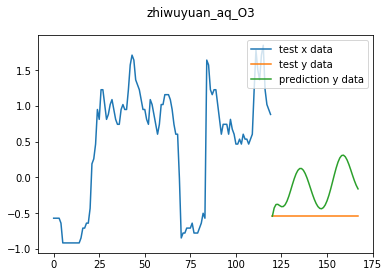

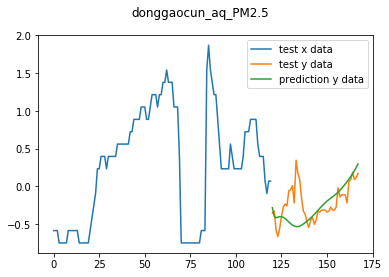

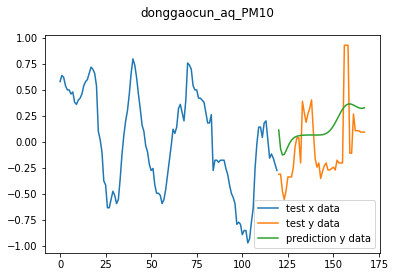

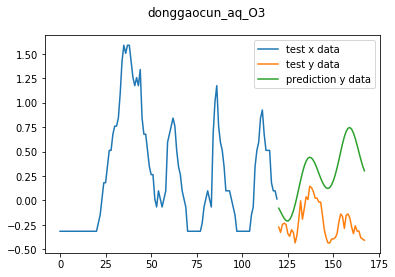

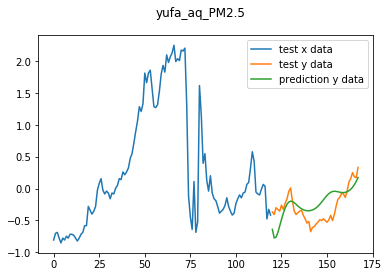

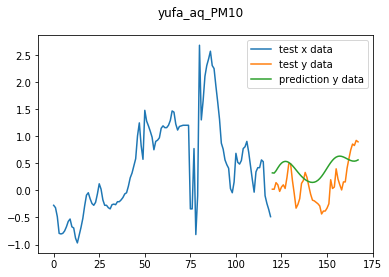

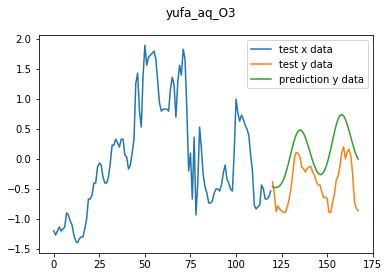

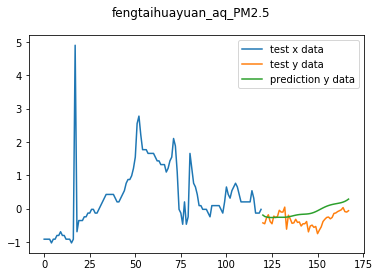

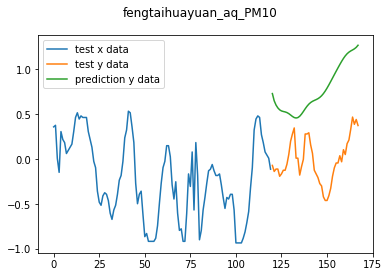

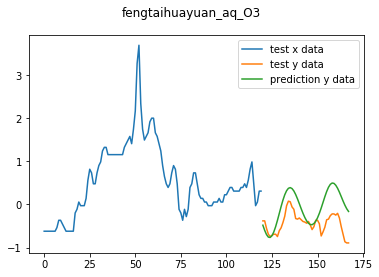

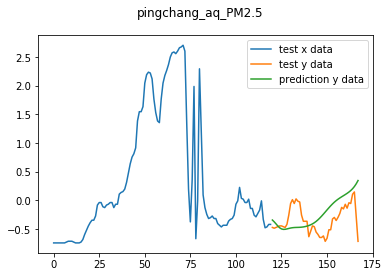

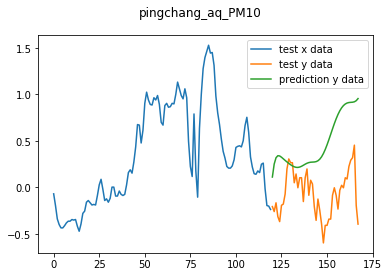

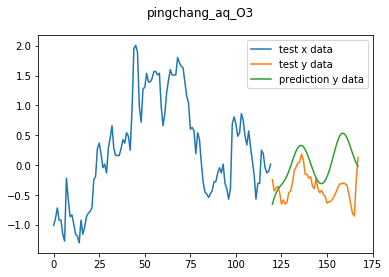

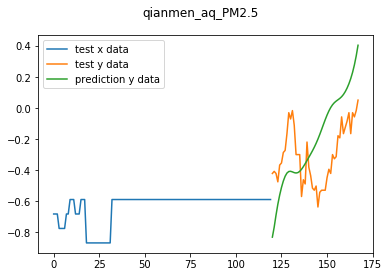

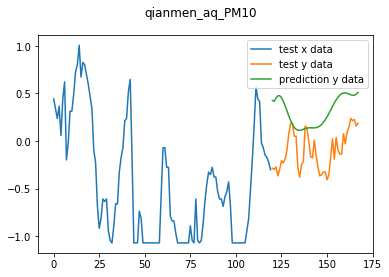

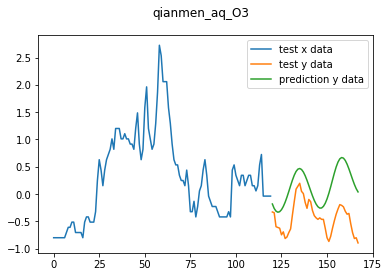

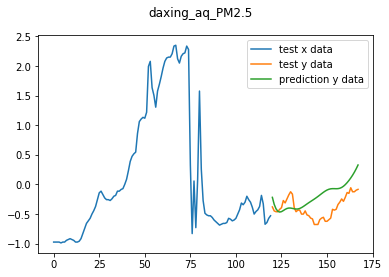

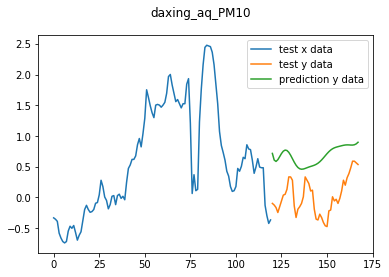

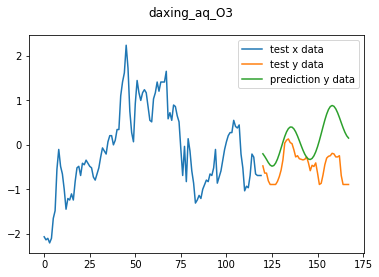

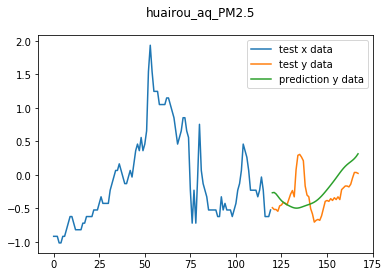

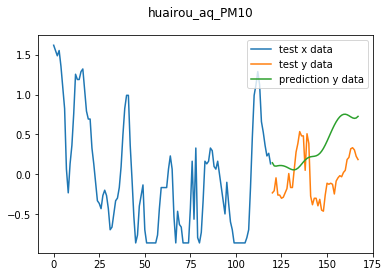

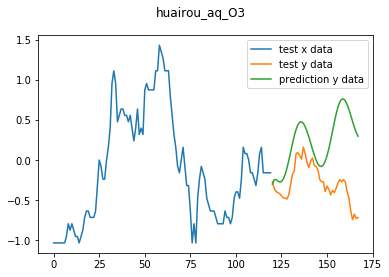

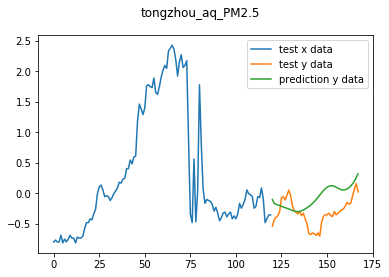

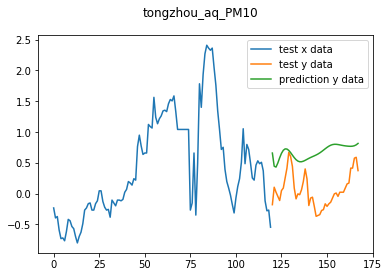

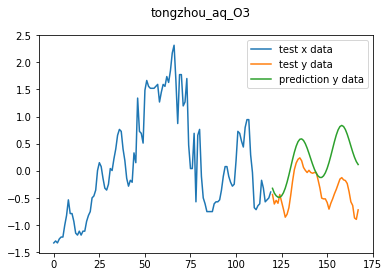

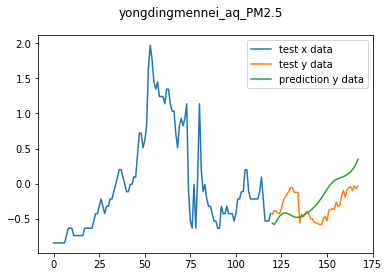

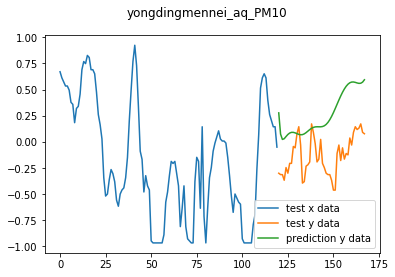

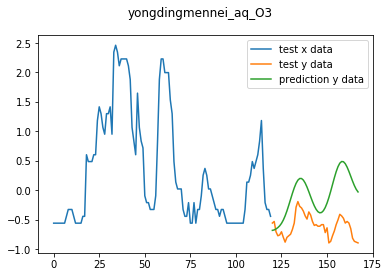

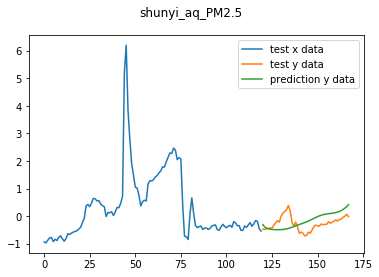

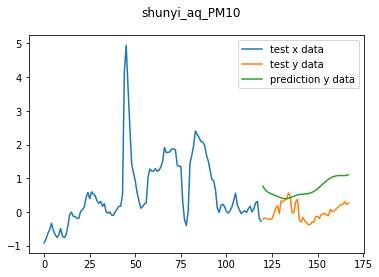

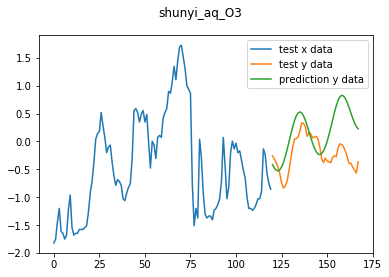

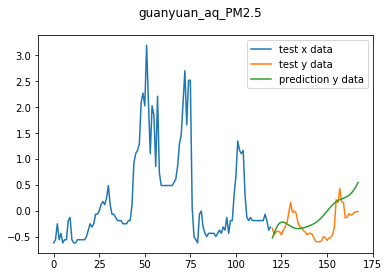

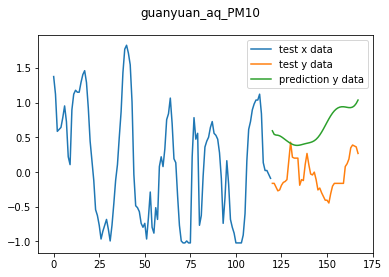

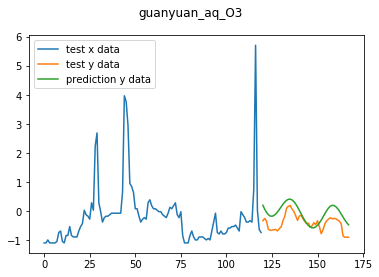

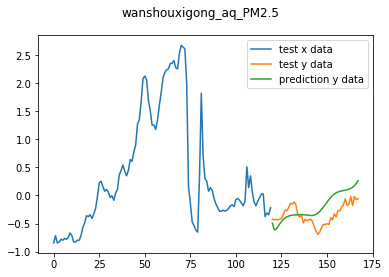

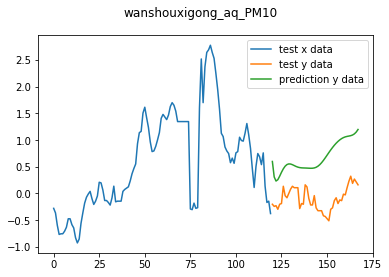

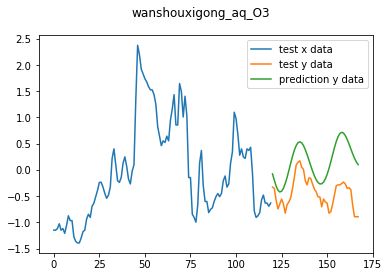

In [23]:
# 预测值普遍在 O3 上表现较好，另外两个参数　PM2.5 和　PM10 上通常捕捉不到高频分量
for i in range(len(output_features)):
    plot_forecast_and_actual_example(test_x, test_y, final_preds, output_features, index=0, feature_index=i)

### 某个特征在整个dev数据集时间跨度上的表现

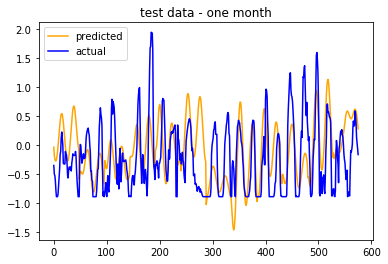

In [32]:
## remove duplicate hours and concatenate into one long array
feature_index = 2
test_y_expand = np.concatenate([test_y[i,:,feature_index] for i in range(0, test_y.shape[0], output_seq_len)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i,:,feature_index] for i in range(0, final_preds.shape[0], output_seq_len)], axis = 0)
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()

### Smapes of all features

In [25]:
aver_smapes, smapes_of_features = SMAPE_on_dataset(test_y, final_preds, output_features, 24)

In [26]:
smapes_of_features

{'aotizhongxin_aq_O3': 1.2012893230042017,
 'aotizhongxin_aq_PM10': 1.2554883946543507,
 'aotizhongxin_aq_PM2.5': 1.4135418142850462,
 'badaling_aq_O3': 1.145339831938363,
 'badaling_aq_PM10': 1.204452276594295,
 'badaling_aq_PM2.5': 1.235169368693228,
 'beibuxinqu_aq_O3': 1.0896264288871464,
 'beibuxinqu_aq_PM10': 1.2139448050104764,
 'beibuxinqu_aq_PM2.5': 1.3550756420480283,
 'daxing_aq_O3': 1.180868827105957,
 'daxing_aq_PM10': 1.0978621497478565,
 'daxing_aq_PM2.5': 1.4155607750724324,
 'dingling_aq_O3': 1.3204060527935115,
 'dingling_aq_PM10': 1.2827862515708328,
 'dingling_aq_PM2.5': 1.3095740673131904,
 'donggaocun_aq_O3': 1.3694132842445785,
 'donggaocun_aq_PM10': 1.3742104304325526,
 'donggaocun_aq_PM2.5': 1.4059177853163642,
 'dongsi_aq_O3': 1.1359430095699736,
 'dongsi_aq_PM10': 1.1876011383878737,
 'dongsi_aq_PM2.5': 1.4237866923333486,
 'dongsihuan_aq_O3': 0.8810134954779786,
 'dongsihuan_aq_PM10': 1.3347033354806899,
 'dongsihuan_aq_PM2.5': 1.3591604415088898,
 'fangshan

In [27]:
aver_smapes

1.237813638977317